## Using Machine Learning to determine the drivers of housing prices during a time of market downfall (post-1998 financial crisis)
Book # 4

- Explore the dataset
- Train, test & holdout
- Perform Regression models
- Extract information for coefficients

**Goal : Identify what are the Sale Price drivers during a property market downfall.**

Note: full address was kept within the dataset for prediction, but was removed from the coef list since it gave too much noise for coef interpretation. 




In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'input/'

In [ ]:
# packages to import

%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost import plot_importance,XGBClassifier,XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import r2_score

from scipy.stats import skew

In [ ]:
file_path = '/content/gdrive/My Drive/resale-flat-prices/'

In [ ]:
# importing dataframes

df_low = pd.read_csv(file_path + 'df_low_p4.csv')


###**Central Area Housing Prices & Drivers During an Economic Decline**

In [ ]:
# Central Area 

df_low = df_low[df_low['month'] < '1999-01-01']
df_central = df_low[df_low['region'] == 'Central']

Skew is:  0.763059942181637


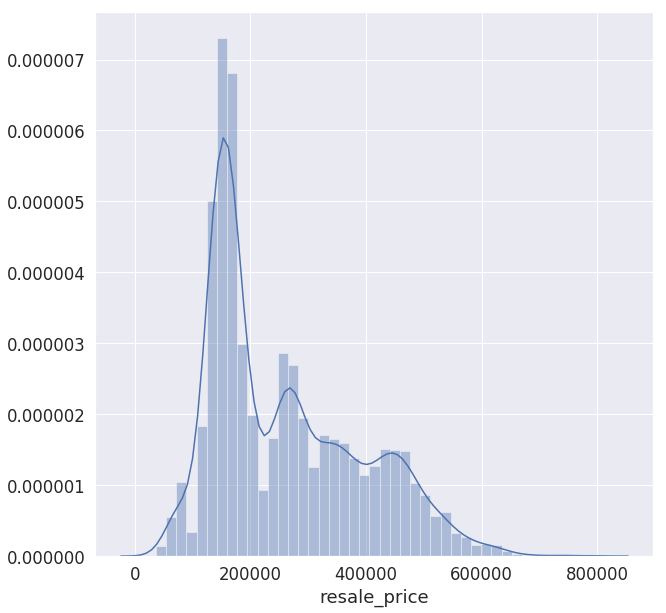

In [6]:
# Target 
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.distplot(df_central['resale_price'])
print('Skew is: ',skew(df_central['resale_price']))

**The housing prices seem to be abnormally distributed, try per square feet**

Skew is:  0.22511558027825176


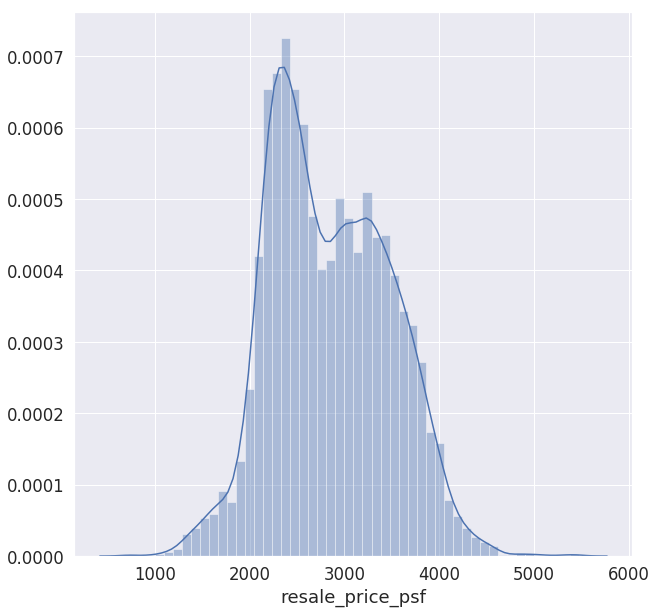

In [7]:
# Target : Resale Price per sqaure foot 
sns.distplot(df_central['resale_price_psf'])
print('Skew is: ',skew(df_central['resale_price_psf']))

**Housing prices are less skewed, but are bimodal, try log transform**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Skew is:  -0.377029352937877


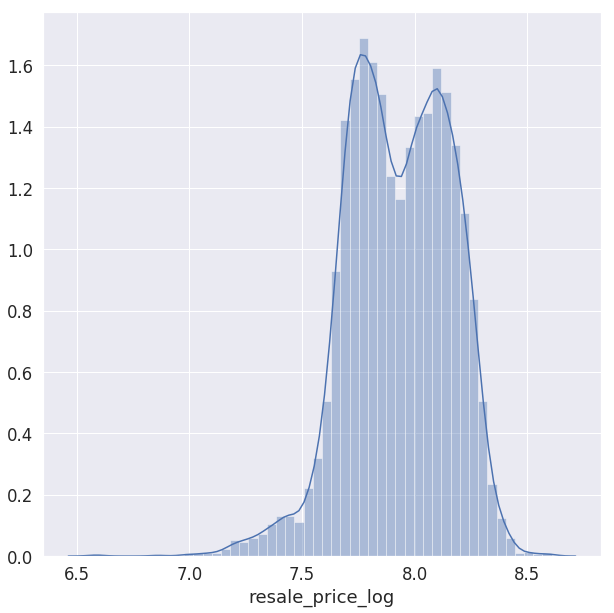

In [8]:
df_central['resale_price_log'] = df_central['resale_price_psf'].apply(lambda x : np.log(x))

sns.distplot(df_central['resale_price_log'])
print('Skew is: ',skew(df_central['resale_price_log']))


**Log transform is worst. Keep Per square foot housing prices**


In [ ]:
cat_features = ['town', 'flat_type', 'storey_range', 'flat_model',
                'full_address', 'nearest_mrt','nearest_school']
       
num_features = ['lease_commence_date', 'remaining_lease', 'max_floor_lvl','total_dwelling_units' ,'1room_sold', '2room_sold','3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
        'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental','other_room_rental', 'Latitude', 'Longitude',
       'nearest_distance','nearest_distance_school', 'Ranking', 'Tot_Vacancy','perc_balance_vacancy', 'Month']

dum_features = ['residential','commercial', 'market_hawker', 'miscellaneous', 'multistorey_carpark',
       'precinct_pavilion', 'is_interchange']



# Transforming the data into a new proper dataframe
def creating_dataframe(df):

  
  # Get dummified values
  dummies = pd.get_dummies(df[cat_features], drop_first = True)
  print('Added Columns from Dummies :', dummies.shape[1])
  dummies.reset_index(drop = True, inplace = True)
  
  #Dummies Dataframe
  df.reset_index(drop = True, inplace = True)
  dummies = pd.concat([dummies, df[dum_features]], axis = 1)
  
  # Standard Scaling 
  std = StandardScaler()
  num_std = pd.DataFrame(std.fit_transform(df[num_features]))
  num_std.columns = num_features
  num_std.reset_index(drop = True, inplace = True)
  
  X = pd.concat([num_std, dummies], axis = 1)
  print('Total Number of Columns :', X.shape[1])
  print('Total Number of Rows :', X.shape[0])
  
  df = pd.concat([df[['resale_price_psf']],X], axis = 1)
  
  return df



  
# To get the scaler only 
def std_scaler(df):
  num_features = ['lease_commence_date', 'remaining_lease', 'max_floor_lvl','total_dwelling_units' ,'1room_sold', '2room_sold','3room_sold', '4room_sold', '5room_sold', 'exec_sold', 'multigen_sold',
        'studio_apartment_sold', '1room_rental', '2room_rental', '3room_rental','other_room_rental', 'Latitude', 'Longitude',
       'nearest_distance','nearest_distance_school', 'Ranking', 'Tot_Vacancy','perc_balance_vacancy', 'Month']
  
  # Standard Scaling 
  std = StandardScaler()
  std = std.fit(df[num_features])
  
  return std
  

In [10]:
new_central_df = creating_dataframe(df_central)

Added Columns from Dummies : 1321
Total Number of Columns : 1352
Total Number of Rows : 11167


In [ ]:
# Define y (target) as the resale price per square foot
X = new_central_df.drop(columns = ['resale_price_psf'])
y = new_central_df['resale_price_psf']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [13]:
ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.89313346 0.90303382 0.89110332]
0.8957568661074534
1.0


In [14]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.9142959363019414


**Extract coefficients to see dolar values**
Note: coefficients need to be transformed using the standard scaler to derive the monetary value.

In [ ]:
std = std_scaler(df_central)

In [ ]:
def coef_dataframe(X):
  conversion_of_coef_list =[tuple(ridge.coef_)]
  coefs = pd.DataFrame(conversion_of_coef_list, columns = X.columns, index = ['Dollar Value ($)'])

  # Reversing the Standardardization of the numerical stardardized values
  coefs[num_features] = std.transform(coefs[num_features])
  
  # new DataFrame with the coefficients 
  dollar_values = pd.DataFrame(X.columns, columns = ['Driver'])
  dollar_values['Dollar Value per Sqft'] = coefs.values.tolist()[0]
  dollar_values = dollar_values[~dollar_values.Driver.str.contains("full_address")]
  
  return dollar_values

In [ ]:
dollar_values_central = coef_dataframe(X)

In [18]:
print('Top 20 Positive Drivers in 1998 in the Central Area')
dollar_values_central.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers in 1998 in the Central Area


,Driver,Dollar Value per Sqft
50,flat_model_terrace,1672.281638
35,flat_type_5 ROOM,540.651388
41,flat_model_apartment,445.847505
29,town_MARINE PARADE,381.868251
1350,precinct_pavilion,380.508197
43,flat_model_maisonette,303.843582
34,flat_type_4 ROOM,289.969577
1342,nearest_school_ Tao Nan School,271.078155
1288,nearest_mrt_BUONA VISTA MRT STATION SINGAPORE,240.493664
1303,nearest_mrt_TANJONG PAGAR MRT STATION SINGAPORE,203.499150


In [19]:
print('Top 20 Negative Drivers in 1998 in the Central Area')
dollar_values_central.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(10)

Top 20 Negative Drivers in 1998 in the Central Area


,Driver,Dollar Value per Sqft
17,Longitude,-2357.988804
40,flat_model_adjoined flat,-1286.654692
32,flat_type_2 ROOM,-768.694081
16,Latitude,-677.172406
1328,nearest_school_ Maha Bodhi School,-325.957811
48,flat_model_simplified,-287.830109
0,lease_commence_date,-266.303416
1295,nearest_mrt_KEMBANGAN MRT STATION SINGAPORE,-264.111754
24,town_BUKIT MERAH,-259.537545
1345,residential,-255.962035


###**Major Positive Driver of Prices in the Central Area During an Economic Decline**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

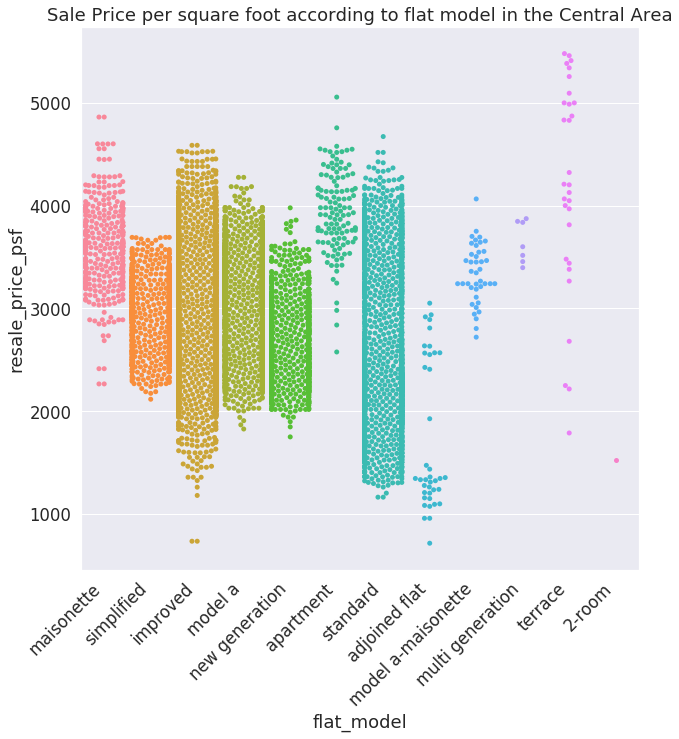

In [20]:
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.swarmplot(x = 'flat_model', y = 'resale_price_psf', data = df_central)
plt.title('Sale Price per square foot according to flat model in the Central Area')
plt.xticks(rotation = 45, ha='right')

###**Eastern Area Housing Prices & Drivers During an Economic Decline**

In [ ]:
# Eastern Area of Singapore 

df_low = df_low[df_low['month'] < '1999-01-01']
df_east = df_low[df_low['region'] == 'East']

Skew is:  0.3937775666564861


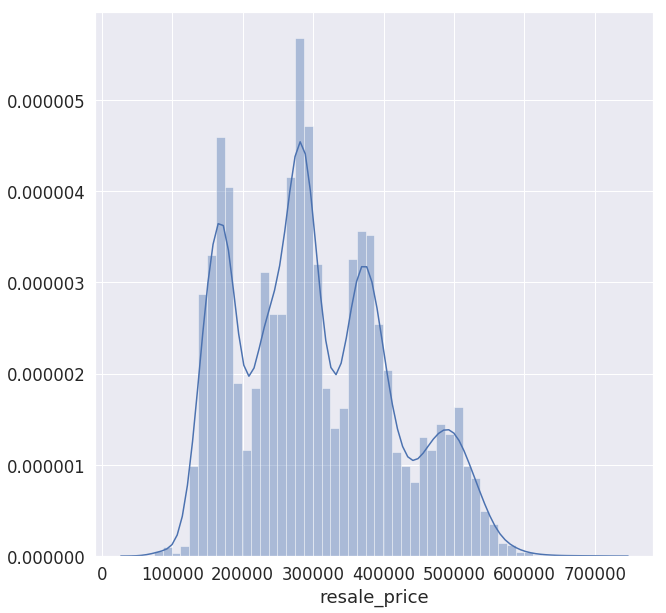

In [22]:
# Target 
sns.distplot(df_east['resale_price'])
print('Skew is: ',skew(df_east['resale_price']))

**Highly distributed Sale Prices, not good**

Skew is:  0.2254474922003148


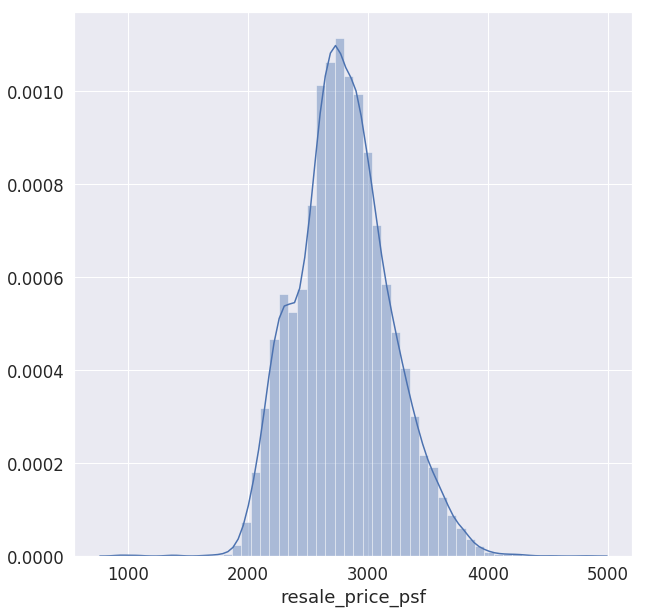

In [23]:
# Target : Resale Price per sqaure foot 
sns.distplot(df_east['resale_price_psf'])
print('Skew is: ',skew(df_east['resale_price_psf']))

**Good distribution & Small skew, no need for log transform**

In [24]:
new_eastern_df = creating_dataframe(df_east)

Added Columns from Dummies : 1245
Total Number of Columns : 1276
Total Number of Rows : 16338


In [ ]:
# Define y (target) as the resale price per square foot
X = new_eastern_df.drop(columns = ['resale_price_psf'])
y = new_eastern_df['resale_price_psf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [26]:
ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.85692589 0.86093112 0.8505891 ]
0.8561486988303741
1.0


In [27]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.8613814954075963


In [ ]:
std = std_scaler(df_east)

In [ ]:
dollar_values_eastern = coef_dataframe(X)

In [30]:
print('Top 20 Positive Drivers in 1998 in the Eastern Area')
dollar_values_eastern.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers in 1998 in the Eastern Area


,Driver,Dollar Value per Sqft
28,flat_type_5 ROOM,637.994346
34,flat_model_apartment,548.999663
36,flat_model_maisonette,506.353010
27,flat_type_4 ROOM,407.877588
29,flat_type_EXECUTIVE,345.244724
32,storey_range_20-30,264.532124
1249,nearest_school_ Eunos Primary School,164.381938
26,flat_type_3 ROOM,85.710342
1261,nearest_school_ St. Stephen’s School,81.199574
1248,nearest_school_ Elias Park Primary School,73.412708


In [184]:
print('Top 10 Negative Drivers in 1998 in the Eastern Area')
dollar_values_eastern.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(10)

Top 10 Negative Drivers in 1998 in the Eastern Area


,Driver,Dollar Value per Sqft
17,Longitude,-3562.388875
16,Latitude,-1173.554881
33,flat_model_adjoined flat,-972.945914
945,full_address_58 CHAI CHEE DR Singapore,-313.195182
45,full_address_101 BEDOK RESERVOIR RD Singapore,-293.674339
0,lease_commence_date,-267.972524
109,full_address_112 BEDOK RESERVOIR RD Singapore,-264.429275
119,full_address_114 BEDOK RESERVOIR RD Singapore,-264.154800
963,full_address_611 BEDOK RESERVOIR RD Singapore,-242.207774
616,full_address_407 TAMPINES ST 41 Singapore,-241.940355


###**Major Positive Driver of Prices in the Eastern Area During an Economic Decline**

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

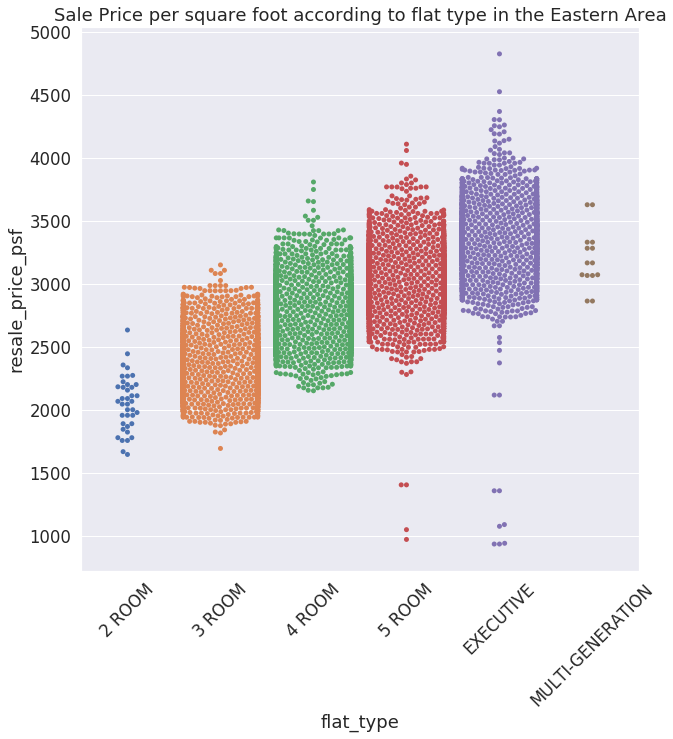

In [172]:
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.swarmplot(x = 'flat_type', y = 'resale_price_psf', data = df_east)
plt.title('Sale Price per square foot according to flat type in the Eastern Area')
plt.xticks(rotation = 45)

###**Western Area Housing Prices & Drivers During an Economic Decline**

In [ ]:
# Western area of Singapore
df_west = df_low[df_low['region'] == 'West']

Skew is:  0.7685022441644713


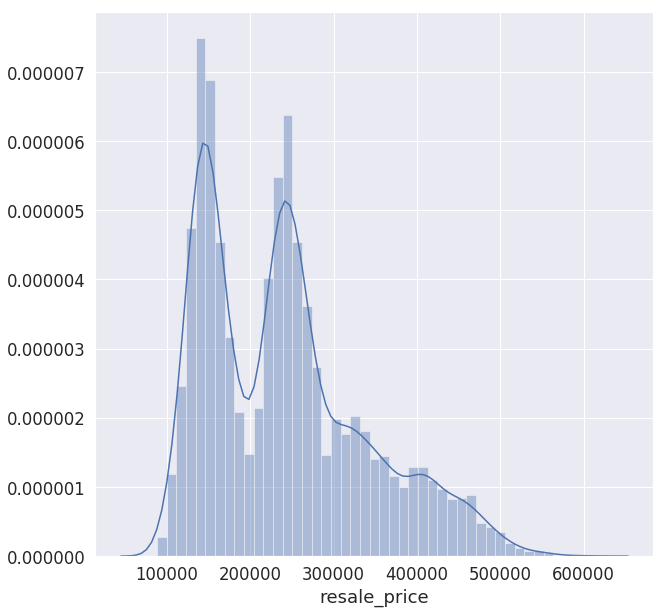

In [32]:
# Target 
sns.distplot(df_west['resale_price'])
print('Skew is: ',skew(df_west['resale_price']))

**The distribution of prices is bimodal**

Skew is:  0.49030430851829804


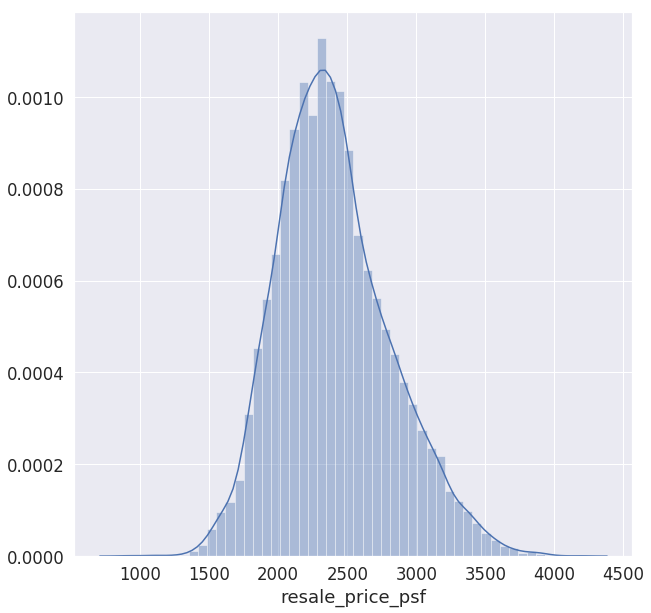

In [33]:
# Target 
sns.distplot(df_west['resale_price_psf'])
print('Skew is: ',skew(df_west['resale_price_psf']))

**The distribution of prices is normal, but slightly skewed.**

In [34]:
new_west_df = creating_dataframe(df_west)

Added Columns from Dummies : 1305
Total Number of Columns : 1336
Total Number of Rows : 13784


In [35]:
# Define y (target) as the resale price per square foot
X = new_west_df.drop(columns = ['resale_price_psf'])
y = new_west_df['resale_price_psf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.88377326 0.88558242 0.89393268]
0.8877627879853437
1.0


In [36]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.8927198207191681


In [ ]:
std = std_scaler(df_west)

In [ ]:
dollar_values_west = coef_dataframe(X)

In [39]:
print('Top 20 Positive Drivers in 1998 in the Western Area')
dollar_values_west.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers in 1998 in the Western Area


,Driver,Dollar Value per Sqft
34,flat_model_apartment,1011.517508
36,flat_model_maisonette,911.416233
30,flat_type_5 ROOM,640.593060
17,Longitude,570.927453
29,flat_type_4 ROOM,342.689868
39,flat_model_new generation,323.515996
37,flat_model_model a,318.534664
35,flat_model_improved,312.073885
31,flat_type_EXECUTIVE,235.555635
38,flat_model_model a-maisonette,215.391539


In [40]:
print('Top 10 Negative Drivers in 1998 in the Western Area')
dollar_values_west.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(10)

Top 10 Negative Drivers in 1998 in the Western Area


,Driver,Dollar Value per Sqft
16,Latitude,-2539.543426
0,lease_commence_date,-417.959027
13,2room_rental,-269.417578
18,nearest_distance,-146.892830
1294,nearest_mrt_LAKESIDE MRT STATION SINGAPORE,-140.914367
1296,nearest_school_ Boon Lay Garden Primary School,-127.878047
14,3room_rental,-112.677757
1325,nearest_school_ Westwood Primary School,-108.596526
1324,nearest_school_ West Grove Primary School,-98.069920
1316,nearest_school_ Pioneer Primary School,-98.025290


###**Major Positive Driver of Prices in the West Area During an Economic Decline**

**Similar to the other areas, the flat model and type are major contributors of price increase. But contrary to the others, Longitude is a major positive rather than negative factor for the west**

What we see in the graph below is that the same size of flat could get more value per sqft if it was nearer to the city center (Higher Longitude). 

(array([103.68, 103.7 , 103.72, 103.74, 103.76, 103.78, 103.8 ]),
 <a list of 7 Text xticklabel objects>)

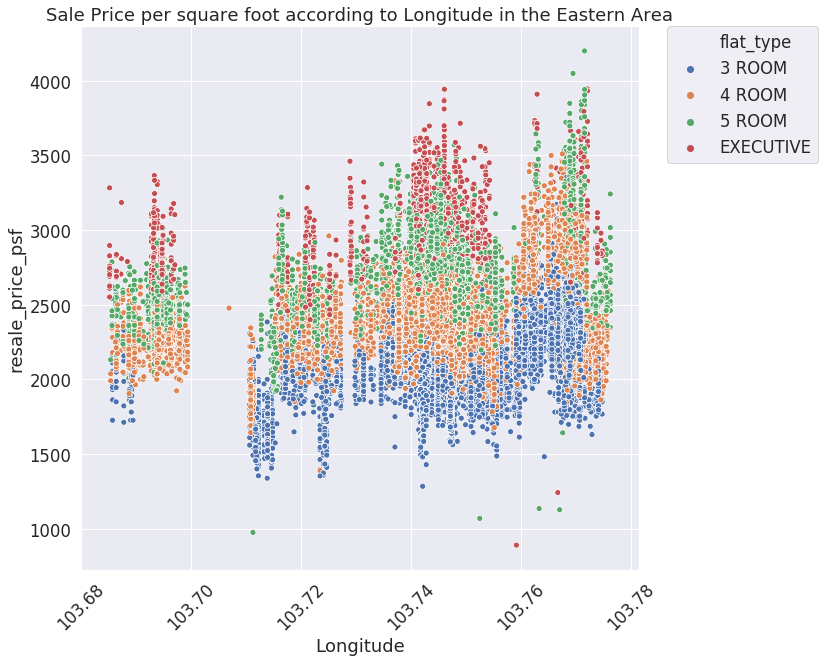

In [198]:

sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.scatterplot(x = 'Longitude', y = 'resale_price_psf', data = df_west, hue = 'flat_type')
plt.title('Sale Price per square foot according to Longitude in the Western Area')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45)

(array([103.68, 103.7 , 103.72, 103.74, 103.76, 103.78, 103.8 ]),
 <a list of 7 Text xticklabel objects>)

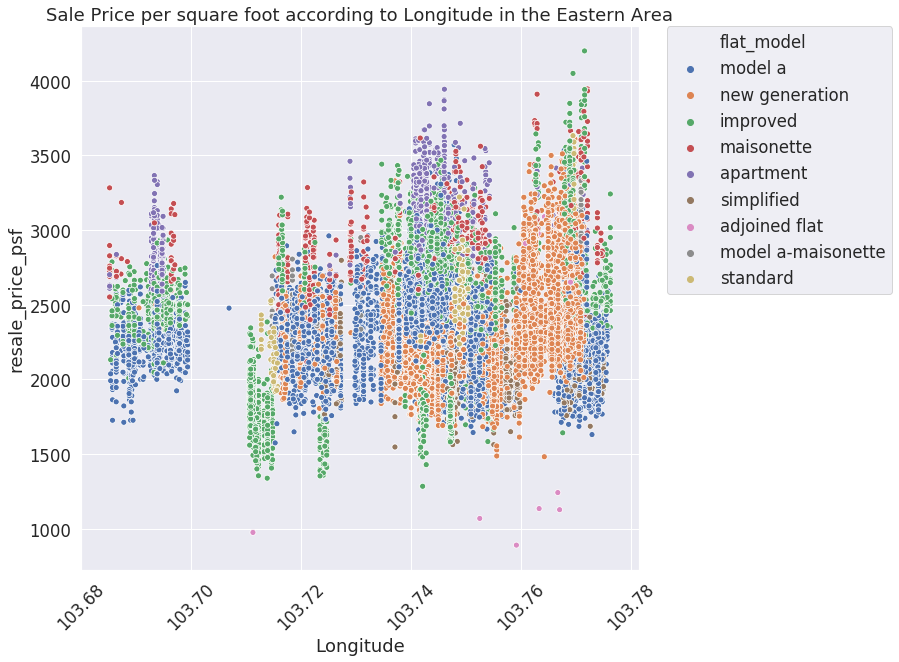

In [197]:

sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.scatterplot(x = 'Longitude', y = 'resale_price_psf', data = df_west, hue = 'flat_model')
plt.title('Sale Price per square foot according to Longitude in the Western Area')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45)

**Here we also observe that the type of homes is not the same accross the different latitudes, which may be why the price is higher in the eastern part of the west**

###**Northern Area Housing Prices & Drivers During an Economic Decline**

In [ ]:
# Northern area of Singapore
df_north = df_low[df_low['region'] == 'North']

Skew is:  1.0510801817298105


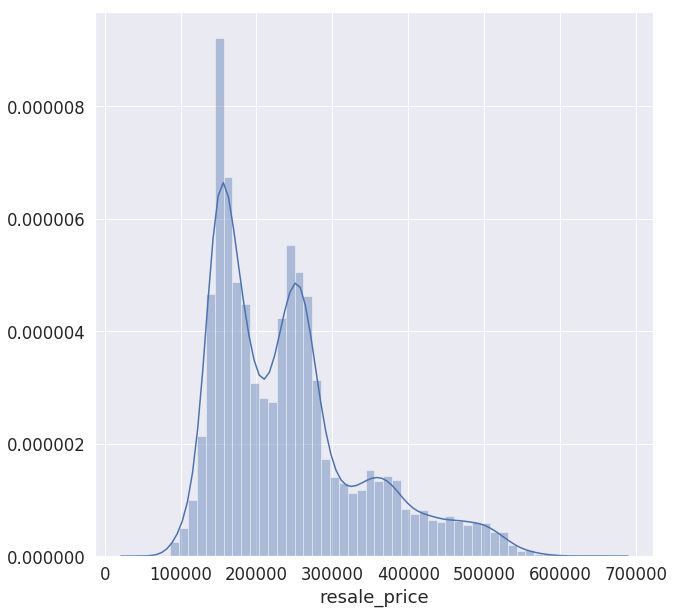

In [202]:
# Target 
sns.distplot(df_north['resale_price'])
print('Skew is: ',skew(df_north['resale_price']))

**The data is very skewed and tri-modal ??**

Skew is:  0.44335000103685235


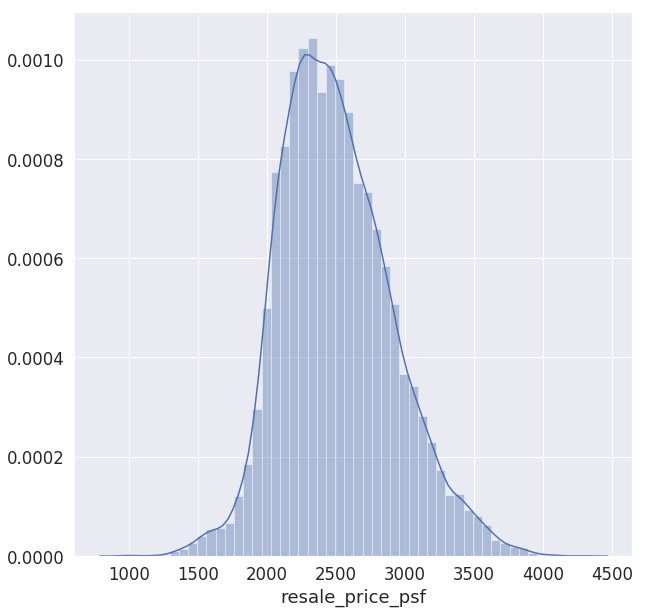

In [204]:
# Target 
sns.distplot(df_north['resale_price_psf'])
print('Skew is: ',skew(df_north['resale_price_psf']))

**Correcting for the square footage makes the data much better**

In [212]:
new_north_df = creating_dataframe(df_north)

Added Columns from Dummies : 1546
Total Number of Columns : 1577
Total Number of Rows : 16494


In [213]:
# Define y (target) as the resale price per square foot
X = new_north_df.drop(columns = ['resale_price_psf'])
y = new_north_df['resale_price_psf']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

ridge_alphas = np.logspace(-2, 7, 10)
ridge = RidgeCV(alphas=ridge_alphas, cv=3)
ridge_scores = cross_val_score(ridge, X_train,y_train,cv=3)
ridge.fit(X_train,np.ravel(y_train))
print(ridge_scores)
print(np.mean(ridge_scores))
print(ridge.alpha_)

[0.87624038 0.88522666 0.88561798]
0.8823616707180163
1.0


In [218]:
y_pred = ridge.predict(X_test)
print(r2_score(y_test, y_pred))

0.8866787475299867


In [ ]:
std = std_scaler(df_north)

In [ ]:
dollar_values_northern = coef_dataframe(X)

In [220]:
print('Top 20 Positive Drivers in 1998 in the Northen Area')
dollar_values_northern.sort_values(by = 'Dollar Value per Sqft', ascending = False).head(20)

Top 20 Positive Drivers in 1998 in the Northen Area


,Driver,Dollar Value per Sqft
35,flat_model_apartment,905.886549
38,flat_model_maisonette,860.122698
30,flat_type_5 ROOM,663.712091
36,flat_model_improved,449.402137
42,flat_model_new generation,422.448678
39,flat_model_model a,399.170705
40,flat_model_model a-maisonette,394.075105
502,full_address_259 ANG MO KIO AVE 2 Singapore,369.116313
29,flat_type_4 ROOM,351.459162
785,full_address_406 SERANGOON AVE 1 Singapore,342.903006


In [221]:
print('Top 10 Negative Drivers in 1998 in the Northern Area')
dollar_values_northern.sort_values(by = 'Dollar Value per Sqft', ascending = True).head(10)

Top 10 Negative Drivers in 1998 in the Northern Area


,Driver,Dollar Value per Sqft
16,Latitude,-4846.636291
17,Longitude,-664.014813
946,full_address_5 MARSILING DR Singapore,-377.629962
138,full_address_123 SERANGOON NTH AVE 1 Singapore,-321.232959
1188,full_address_632 YISHUN ST 61 Singapore,-287.955608
0,lease_commence_date,-270.402119
667,full_address_331 WOODLANDS AVE 1 Singapore,-264.855333
1415,full_address_8 MARSILING DR Singapore,-261.026696
970,full_address_509 ANG MO KIO AVE 8 Singapore,-256.622107
692,full_address_338 HOUGANG AVE 7 Singapore,-239.143768


###**Major Positive Driver of Prices in the Northern Area During an Economic Decline**

**Similar to the other regions, the flat type and model are major contributors to housing prices.**

**What has yet to be looked at is how the newest flats were more expensive per sqft. Therefore, newer flats (i.e those who just came into the market) were more expensive and most likely modern.**

- Although the trend is observed accross, one of the main reason why this may be the case is that bigger glats were being built in the later years and thus they became more expensive. 
- We can see that the 1992 flat prices are much higher. This could be due to the newer BTO flats being released on the market.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

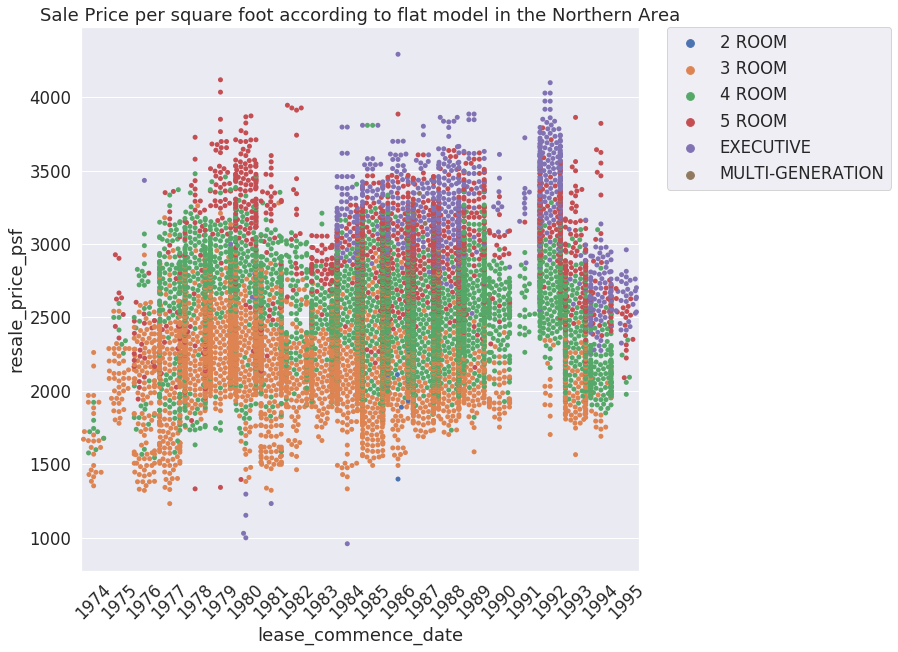

In [229]:
sns.set(rc={'figure.figsize':(10,10)},  font_scale=1.5)
sns.swarmplot(x = 'lease_commence_date', y = 'resale_price_psf', data = df_north, hue = 'flat_type')
plt.title('Sale Price per square foot according to flat model in the Northern Area')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation = 45)

###**Conclusion**

**Drivers of the Property Market in an economic decline**

**THE BIGGER THE BETTER**

- Flat Size
- Flat Type
- Flat Model
- Newer Flats
- Closeness to the Central Area

**Interestingly, the average home price in the central area is similar to the east. Could it be that people could not longer afford living in the central area and seeked to move out ? Maybe flats were bigger and more interesting for families in the east and people purchased homes in those area instead. I.e Bigger the Better**

In [234]:
print('Mean Home Price in the Central Area: ', int(df_central['resale_price'].mean()), '// Price Per Sqft:',int(df_central['resale_price_psf'].mean()))
print('Mean Home Price in the Eastern Area: ', int(df_east['resale_price'].mean()), '// Price Per Sqft:',int(df_east['resale_price_psf'].mean()))
print('Mean Home Price in the Western Area: ', int(df_west['resale_price'].mean()), '// Price Per Sqft:',int(df_west['resale_price_psf'].mean()))
print('Mean Home Price in the Northern Area: ', int(df_north['resale_price'].mean()), '// Price Per Sqft:',int(df_north['resale_price_psf'].mean()))


Mean Home Price in the Central Area:  259899 // Price Per Sqft: 2845
Mean Home Price in the Eastern Area:  302656 // Price Per Sqft: 2796
Mean Home Price in the Western Area:  241328 // Price Per Sqft: 2403
Mean Home Price in the Northern Area:  242005 // Price Per Sqft: 2501
